In [29]:
#Importing all necessary modules
import pandas as pd
import numpy as np
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import re
import multiprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
nltk.download("stopwords")
sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dinakarmurthy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
#Importing the data
Full_data = pd.read_csv("training.1600000.processed.noemoticon.csv", 
                   encoding = "ISO-8859-1", 
                   names = ["target", "ids", "date", "flag", "user", "text"])
Full_data.head()
max_len = max([len(x) for x in Full_data['text']])
max_len

374

In [31]:
# taking 200000 from the dataset
data = Full_data.sample(200000)

In [32]:
data.describe(include = "all")

,target,ids,date,flag,user,text
count,200000.000000,2.000000e+05,200000,200000,200000,200000
unique,NaN,NaN,175401,1,148225,199138
top,NaN,NaN,Fri May 29 19:53:13 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,6,200000,60,35
mean,2.003440,1.998367e+09,NaN,NaN,NaN,NaN
std,2.000002,1.935915e+08,NaN,NaN,NaN,NaN
min,0.000000,1.467811e+09,NaN,NaN,NaN,NaN
25%,0.000000,1.956901e+09,NaN,NaN,NaN,NaN
50%,4.000000,2.001925e+09,NaN,NaN,NaN,NaN
75%,4.000000,2.176897e+09,NaN,NaN,NaN,NaN


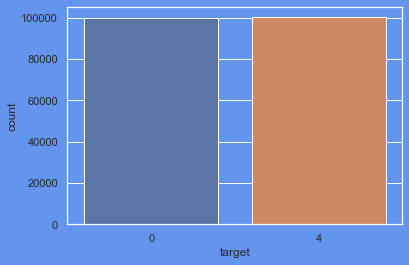

In [33]:
sns.countplot(x = data['target']);
#This show that the data is equally distributed between positive and negetive sentiments.

In [34]:
data.drop(['ids', 'date', 'flag','user'], axis = 1)
#These columns cannot be used for analysis.

,target,text
1171434,4,@davebaldwin you can create groups in PB Lite ...
499841,0,"@fErNniii yep, our home computer is broke, so ..."
315692,0,@ryszu I'm happy to submit patches for broken ...
1276663,4,GoodNight All
1581913,4,jonas brothers was amazing
...,...,...
1373796,4,"@MaryKateOlsen9 Thanks for the link to Ash, MK..."
649705,0,"monumental dissapointment, tried 3 stores no i..."
1336792,4,"@xoxotreason well im doing filing, going throu..."
1270184,4,@Taphophile_au chili pumpkin soup sounds prett...


In [35]:
data['target']=data['target'].replace(4,1)
#Here 4 represents +ve sentiment, it is not a measure so to make things easy I am converting it 
#into a binary classification.

In [36]:
#Spliting the data into target and features
X = data["text"]
y = np.array(data["target"])

In [37]:
X.iloc[1]
#This is the first line of our data.

'@fErNniii yep, our home computer is broke, so I have to share mine.  '

In [38]:
#defining functions used for cleaning the data
def text_splitting(text): #used to split words based on white spaces
    words = text.split()
    return words

def lower_case(words): #converting texts to lower case (for uniformity)
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words): #used to remove punctuation marks
    reg_punc = re.compile('[%s]' % re.escape(string.punctuation)) #The regex used to remove punctuations.
    stripped_words = [reg_punc.sub('', w) for w in words]
    return stripped_words

def only_alphabets(stripped_words): # removing all digits / storing only alphabets for training
    stripped_words = [word for word in stripped_words if word.isalpha()]
    return stripped_words

def remove_stopwords(words): #removing frequently used words such as and, of, is. as. etc (stop words)
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words): #joining split words into a sentence
    return ' '.join(words)

def remove_noise(text):
    words = text_splitting(text)
    words = lower_case(words)
    words = remove_punctuation(words)
    words = only_alphabets(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [39]:
#applying all functions to the features, training and testing data.
X = X.apply(remove_noise)
X.head()

1171434    davebaldwin create groups pb lite shiftclick u...
499841           fernniii yep home computer broke share mine
315692     ryszu im happy submit patches broken tests fee...
1276663                                            goodnight
1581913                               jonas brothers amazing
Name: text, dtype: object

In [41]:
#splittng the data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.20, random_state = 272,
                                                           stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.2, random_state = 272,
                                                 stratify = y_temp)

In [42]:
# creating tokens for training the model
tokenizer = Tokenizer(num_words = 20000, oov_token = "<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index)+1
vocab_size

116608

In [47]:
#determing the longest text in the training and testing data for the model parameters
maxlen = max(len(x) for x in X_train)
X_train.head()
maxlen2 = max(len(x) for x in X_test)
maxlen
maxlen3 = max(len(x) for x in X_val)
maxlen

134

In [48]:
#creating sequences for training and testing
training_sequence = tokenizer.texts_to_sequences(X_train)
training_sequence_padded = pad_sequences(training_sequence, maxlen = maxlen, padding = 'post', 
                                         truncating = 'post')

test_sequence = tokenizer.texts_to_sequences(X_test)
test_sequence_padded = pad_sequences(test_sequence, maxlen = maxlen, padding = 'post', 
                                         truncating = 'post')

val_sequence = tokenizer.texts_to_sequences(X_val)
val_sequence_padded = pad_sequences(val_sequence, maxlen = maxlen, padding = 'post', 
                                         truncating = 'post')

In [53]:
#Creating the model
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, 32, input_length = maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(8,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid'),
    ])

model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])


In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 134, 32)           3731488   
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 32)                0         
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 32)               

In [55]:
# Training the model we created above. 
history =    model.fit(training_sequence_padded, y_train, 
                       validation_data = (val_sequence_padded, y_val),
                                               epochs = 10)

Epoch 1/10
4000/4000 [==============================] - 95s 23ms/step - loss: 0.5472 - accuracy: 0.7218 - val_loss: 0.9382 - val_accuracy: 0.5461
Epoch 2/10
4000/4000 [==============================] - 102s 26ms/step - loss: 0.4663 - accuracy: 0.7804 - val_loss: 0.4960 - val_accuracy: 0.7571
Epoch 3/10
4000/4000 [==============================] - 94s 23ms/step - loss: 0.4298 - accuracy: 0.7997 - val_loss: 0.4948 - val_accuracy: 0.7671
Epoch 4/10
4000/4000 [==============================] - 94s 23ms/step - loss: 0.3965 - accuracy: 0.8165 - val_loss: 0.5049 - val_accuracy: 0.7654
Epoch 5/10
4000/4000 [==============================] - 94s 23ms/step - loss: 0.3626 - accuracy: 0.8343 - val_loss: 0.5546 - val_accuracy: 0.7600
Epoch 6/10
4000/4000 [==============================] - 113s 28ms/step - loss: 0.3344 - accuracy: 0.8475 - val_loss: 0.5607 - val_accuracy: 0.7536
Epoch 7/10
4000/4000 [==============================] - 114s 28ms/step - loss: 0.3099 - accuracy: 0.8592 - val_loss: 0.651

1250/1250 [==============================] - 6s 5ms/step - loss: 0.6851 - accuracy: 0.7416


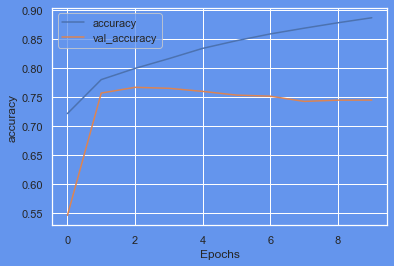

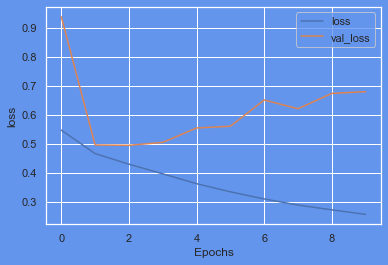

Accuracy on testing set =  0.7415500283241272


In [56]:
loss, accuracy = model.evaluate(test_sequence_padded, y_test)
#plotting accuracy and loss for each epoch
def plot_graphs(model, string):
  plt.plot(model.history[string])
  plt.plot(model.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
print("Accuracy on testing set = ", accuracy)

As shown by the model, it performs well on unseen clean data, with an accuracy of 74.15%. The model's accuracy levels off at 75% for the training data indicating the model maybe overfitting the data and the hyperparameters need to be tuned more and the quality of the data must be improved to get a better accuracy from the model.